# Discriminative Sparse Coding

### import libraries

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import time
import librosa
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import SparseCoder,DictionaryLearning
from sklearn import cluster
# from lightning.regression import CDRegressor
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

In [198]:
import ddsc 

In [199]:
from dataprocess import read_data, format_data, split, split2
df, houses = read_data()
df.head()

,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,
2242,2014-01-01 00:00:00,1.194,0.032,0.013,0.0,0.083,1.066
2242,2014-01-01 01:00:00,1.185,0.032,0.271,0.0,0.078,0.804
2242,2014-01-01 02:00:00,1.307,0.032,0.305,0.0,0.087,0.883
2242,2014-01-01 03:00:00,1.515,0.031,0.648,0.0,0.109,0.727
2242,2014-01-01 04:00:00,1.175,0.032,0.408,0.0,0.092,0.643


In [187]:
d = format_data(df, houses)

timeframe = 336
portion = 0.5

x_train, x_test = split(d, portion, timeframe)


# start_t = 4000 
# x_train, x_test = split2(d, portion, timeframe, start_t)



x_train_sum = x_train.pop('use',None) # aggregated 
x_test_sum = x_test.pop('use',None) 
x_train_localhour = x_train.pop('localhour',None)
x_test_localhour = x_test.pop('localhour',None)
x_test_localhour.iloc[:, 0]

168   2014-01-08 00:00:00
169   2014-01-08 01:00:00
170   2014-01-08 02:00:00
171   2014-01-08 03:00:00
172   2014-01-08 04:00:00
              ...        
331   2014-01-14 19:00:00
332   2014-01-14 20:00:00
333   2014-01-14 21:00:00
334   2014-01-14 22:00:00
335   2014-01-14 23:00:00
Name: 2242, Length: 168, dtype: datetime64[ns]

In [5]:
k = len(x_train.keys())
T, m = x_train[list(x_train.keys())[0]].shape
reg_par = 0.0005
epsilon = 0.001
alpha = 0.001
n = 150
steps = 100 # steps must be higher than k


sc = DDSC(x_train, x_train_sum, alpha, epsilon, reg_par, steps, n, m, T, k)


print('pre-training: ')
A_list,B_list = sc.nnsc()

print('DD: ')
# Discriminative Disaggregation training
B_cat = sc.DD(B_list, A_list)


# Given test examples x_test
A_prime = sc.F(x_test_sum.values, B_cat, A=np.vstack(A_list))
A_last = np.split(A_prime,k,axis=0)

x_predict = sc.predict(A_last,B_list)

pre-training: 
iter 10：A change =   3.9849
iter 20：A change =   0.7306
iter 30：A change =   0.2781
iter 40：A change =   0.1592
iter 50：A change =   0.1039
iter 60：A change =   0.0748
iter 70：A change =   0.0571
iter 80：A change =   0.0452
iter 90：A change =   0.0369
iter 100：A change =   0.0308
Gone through one appliance.

iter 10：A change =   4.4623
iter 20：A change =   1.9060
iter 30：A change =   1.2409
iter 40：A change =   0.6273
iter 50：A change =   0.4012
iter 60：A change =   0.4322
iter 70：A change =   0.4267
iter 80：A change =   0.2880
iter 90：A change =   0.1970
iter 100：A change =   0.1555
Gone through one appliance.

iter 10：A change =   0.9347
iter 20：A change =   0.9441
iter 30：A change =   0.4859
iter 40：A change =   0.3561
iter 50：A change =   0.2052
iter 60：A change =   0.1539
iter 70：A change =   0.1238
iter 80：A change =   0.0980
iter 90：A change =   0.0778
iter 100：A change =   0.0632
Gone through one appliance.

iter 10：A change =   0.3698
iter 20：A change =   0.4029

In [6]:
print("the shape of the first predicted appliances is :%s" %(np.asarray(x_predict[1]).shape,))
x_predict_sum = sum(x_predict)

# energy disaggregation accuracy
acc = sc.accuracy(x_train.values(), x_train_sum, B_list, A_last)
# energy disaggregation error
error, error_star = sc.error(x_train.values(), x_train_sum, B_list, A_list)

print("error: %s, error_star: %s" % (error, error_star))
acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
err_nnsc, err_ddsc = sc.get_error_plot()
# plotting acc/err
a_nnsc, a_ddsc = sc.get_a()
b_nnsc, b_ddsc = sc.get_b()

the shape of the first predicted appliances is :(168, 21)
error: 9.69264056469866, error_star: 244.80816737870458


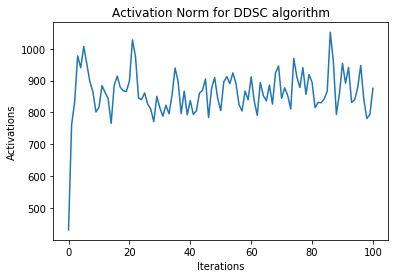

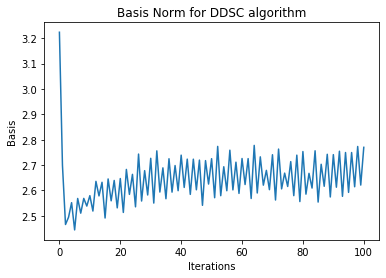

In [7]:
a_nnsc, a_ddsc = sc.get_a()
b_nnsc, b_ddsc = sc.get_b()
plt.plot(a_ddsc)
plt.ylabel('Activations')
plt.xlabel('Iterations')
plt.title('Activation Norm for DDSC algorithm')
plt.show()

plt.plot(b_ddsc)
plt.ylabel('Basis')
plt.xlabel('Iterations')
plt.title('Basis Norm for DDSC algorithm')
plt.show()

In [8]:
print("the shape of the first predicted appliances is :%s" %(np.asarray(list(x_predict)[1]).shape,))


the shape of the first predicted appliances is :(168, 21)


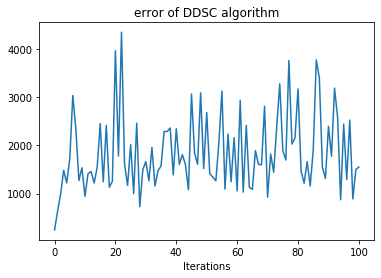

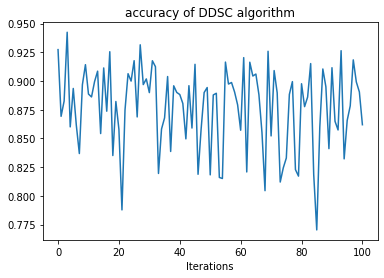

In [9]:
err_nnddsc, err_ddddsc = sc.get_error_plot()
res_err = list(zip(*err_ddddsc)) 
plt.plot(res_err[0])
plt.title('error of DDSC algorithm')
plt.xlabel('Iterations')
plt.show()

acc_nnsc, acc_ddsc = sc.get_accuracy_plot()
res_acc = list(zip(*acc_ddsc)) 
plt.plot(res_acc[0])
plt.title('accuracy of DDSC algorithm')
plt.xlabel('Iterations')
plt.show()


In [10]:
x_predict = sc.predict(A_last,B_list)
print("the shape of the first predicted appliances is :%s" %(np.asarray(list(x_predict)[0]).shape,))

the shape of the first predicted appliances is :(168, 21)


In [ ]:
#x_predict = sc.predict(A_last,B_list)
x_predict = sc.predict(A_list,B_list)

print(np.asarray(list(x_predict)[0])[0:,house])

In [73]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

house = 6

fig = make_subplots(rows=5, cols=1, subplot_titles=('refrigenator', 'dishwasher', 'furance', 'air', 'other'))
df = result_df

dates = df.load_date

y_use_true = np.asarray(x_test_sum)[0:,house]

y_ref_true = np.asarray(x_test[list(x_test.keys())[0]])[0:,house]
y_ref_pred = np.asarray(list(x_predict)[0])[0:,house]


y_dish_true = np.asarray(x_test[list(x_test.keys())[1]])[0:,house]
y_dish_pred = np.asarray(list(x_predict)[1])[0:,house]

y_fur_true = np.asarray(x_test[list(x_test.keys())[2]])[0:,house]
y_fur_pred = np.asarray(list(x_predict)[2])[0:,house]

y_air_true = np.asarray(x_test[list(x_test.keys())[3]])[0:,house]
y_air_pred = np.asarray(list(x_predict)[3])[0:,house]

y_other_true = np.asarray(x_test[list(x_test.keys())[4]])[0:,house]
y_other_pred = np.asarray(list(x_predict)[4])[0:,house]

ref_true = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= y_ref_true,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color='blue'))
    
ref_pred = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= y_ref_pred,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="red"))

dish_true = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= y_dish_true,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color='blue'), showlegend=False)

dish_pred = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= y_dish_pred,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="red"), showlegend=False)

air_true = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= y_air_true,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color='blue'), showlegend=False)

air_pred = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= y_air_pred,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="red"), showlegend=False)

fur_true = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= y_fur_true,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color='blue'), showlegend=False)

fur_pred = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= y_fur_pred,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="red"), showlegend=False)

other_true = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= y_other_true,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color='blue'), showlegend=False)

other_pred = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= y_other_pred,
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="red"), showlegend=False)



# Add traces
fig.append_trace(ref_true, row=1, col=1)
fig.append_trace(ref_pred, row=1, col=1)
fig.append_trace(dish_true, row=2, col=1)
fig.append_trace(dish_pred, row=2, col=1)
fig.append_trace(air_true, row=3, col=1)
fig.append_trace(air_pred, row=3, col=1)
fig.append_trace(fur_true, row=4, col=1)
fig.append_trace(fur_pred, row=4, col=1)
fig.append_trace(other_true, row=5, col=1)
fig.append_trace(other_pred, row=5, col=1)

# Update xaixis properties

# Update yaixis properties
fig.update_yaxes(title_text="Energy (kWh)", row=1, col=1)
fig.update_yaxes(title_text="Energy (kWh)", row=2, col=1)
fig.update_yaxes(title_text="Energy (kWh)", row=3, col=1)
fig.update_yaxes(title_text="Energy (kWh)", row=4, col=1)
fig.update_yaxes(title_text="Energy (kWh)", row=5, col=1)


layout=go.Layout(title='A week of daily consumption for a household', xaxis={'title':'Hour'}, yaxis={'title':'kW'})




fig.update_layout(showlegend=True, height=1000, width=800, title_text="Test set prediction")
fig.show()

Text(0.5, 0, 'Hours')

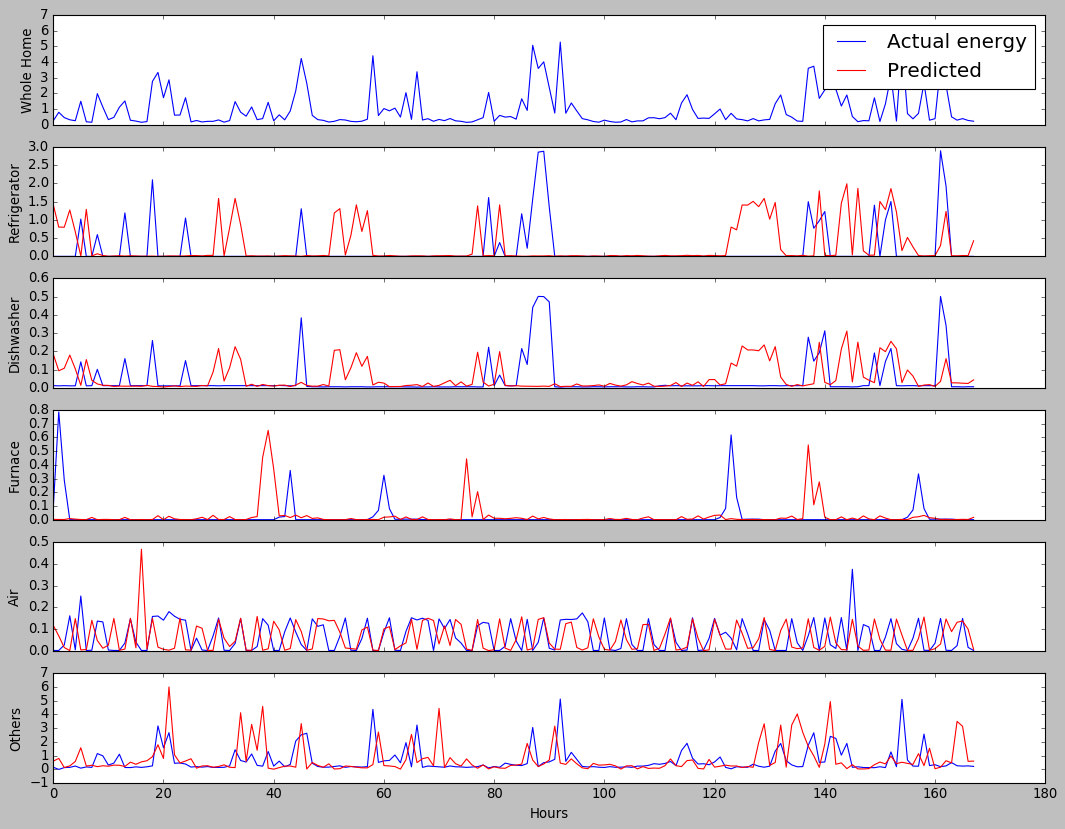

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('classic')
# row and column sharing
house = 6

pie_chart_true = []
pie_chart_pred = []

f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, sharex='col', sharey='row', figsize=(16,12))
x = range(x_train[list(x_train.keys())[0]].shape[0])
plt.rcParams.update({'font.size': 15})


#===========whole home============
y_use_true = np.asarray(x_test_sum)[0:,house]
ax1.plot(x, y_use_true, color='b',label='Actual energy')
y_use_pred = [-1]*x_train[list(x_train.keys())[0]].shape[0]
ax1.plot(x, y_use_pred, color='r', label='Predicted')
ax1.set_ylim([0,7])
ax1.set_ylabel('Whole Home')
ax1.legend()

#===========regrigerator============
y_ref_true = np.asarray(x_test[list(x_test.keys())[0]])[0:,house]
ax2.plot(x, y_ref_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_ref_pred = np.asarray(list(x_predict)[0])[0:,house]
ax2.plot(x, y_ref_pred, color='r')
#ax2.get_yaxis().set_visible(False)
ax2.set_ylabel('Refrigerator')



#===========dishwasher============
y_dish_true = np.asarray(x_test[list(x_test.keys())[1]])[0:,house]
ax3.plot(x, y_dish_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_dish_pred = np.asarray(list(x_predict)[1])[0:,house]
ax3.plot(x,y_dish_pred, color='r')
#ax3.get_yaxis().set_visible(False)
ax3.set_ylabel('Dishwasher')
#ax3.set_ylim(-0.00001)

#===========furnace============
y_fur_true = np.asarray(x_test[list(x_test.keys())[2]])[0:,house]
ax4.plot(x, y_fur_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_fur_pred = np.asarray(list(x_predict)[2])[0:,house]
ax4.plot(x,y_fur_pred, color='r')
#ax4.get_yaxis().set_visible(False)
ax4.set_ylabel('Furnace')
# ax4.set_ylim(-0.05, 0.05)

#===========Air============
y_air_true = np.asarray(x_test[list(x_test.keys())[3]])[0:,house]
ax5.plot(x, y_air_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_air_pred = np.asarray(list(x_predict)[3])[0:,house]
ax5.plot(x, y_air_pred, color='r')
#ax5.get_yaxis().set_visible(False)
ax5.set_ylabel('Air')
# ax5.set_xlabel('Hours')

#===========others============
y_other_true = np.asarray(x_test[list(x_test.keys())[4]])[0:,house]
ax6.plot(x, y_other_true, color='b')
x_predict = sc.predict(A_list,B_list)
y_other_pred = np.asarray(list(x_predict)[4])[0:,house]
ax6.plot(x, y_other_pred, color='r')
#ax5.get_yaxis().set_visible(False)
ax6.set_ylabel('Others')
ax6.set_xlabel('Hours')

In [24]:
x = range(x_train[list(x_train.keys())[0]].shape[0])
y_other_true = np.asarray(x_test[list(x_test.keys())[4]])[0:,house]
y_other_pred = np.asarray(list(x_predict)[4])[0:,house]

result_df = pd.DataFrame({'actuals':y_other_true, 'predicted':y_other_pred})
result_df.head()



,actuals,predicted
0,0.150,0.591328
1,-0.010,0.795810
2,0.124,0.127907
3,0.141,0.249882
4,0.236,0.569673


In [227]:
def generate_df_detect_anomalies(d, house, appliance, x_test, x_test_localhour, x_predict): 
    
    # {'air1': 0, 'furnace1': 1, 'dishwasher1': 2, 'regrigerator1': 3, 'other': 4}
    labels = dict(zip(list(x_test.keys()), range(len(x_test))))
    
    all_hours = d['localhour'].iloc[:, house]   
    all_true = d[appliance].iloc[:, house]
    true_df = pd.concat([all_hours, all_true], axis=1)   
    true_df.columns = ['date', 'actuals']
    
    test_hours = x_test_localhour.iloc[:, house]
    pred_val = pd.Series(x_predict[labels[appliance]][:,house])
    pred_val.index = test_hours.index 
    pred_df = pd.concat([test_hours, pred_val], axis=1)
    pred_df.columns = ['date', 'predicted']

    result_df = pd.merge(true_df, pred_df, on='date', how= 'outer')
    return result_df

result_df = generate_df_detect_anomalies(d, 6, 'other', x_test, x_test_localhour, x_predict)
result_df.head()

,date,actuals,predicted
0,2014-01-01 00:00:00,1.200,NaN
1,2014-01-01 01:00:00,0.473,NaN
2,2014-01-01 02:00:00,0.439,NaN
3,2014-01-01 03:00:00,0.388,NaN
4,2014-01-01 04:00:00,0.427,NaN


In [228]:
def detect_classify_anomalies(df,window):
#     df.replace([np.inf, -np.inf], np.NaN, inplace=True)
#     df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df = df.dropna(how='any')
    df = df.reset_index(drop=True)
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    df['load_date'] = pd.date_range(start='6/1/2014', periods=len(df), freq='H')
#     df = df.sort_values(by='load_date', ascending=False)
#     df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
    return df

df = detect_classify_anomalies(result_df, window=12)
df.head(10)


,date,actuals,predicted,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s,impact,color,region,anomaly_points,load_date
0,2014-01-08 11:00:00,0.452,0.302371,0.149629,33.103859,-0.124753,0.638285,-1.401323,1.151816,-1.241751,0.992245,-1.082180,0.832674,4,0,POSITIVE,NaN,2014-06-01 00:00:00
1,2014-01-08 12:00:00,1.100,0.293278,0.806722,73.338403,-0.020749,0.682183,-1.385114,1.343617,-1.214569,1.173071,-1.044023,1.002525,4,0,POSITIVE,NaN,2014-06-01 01:00:00
2,2014-01-08 13:00:00,0.130,0.204412,-0.074412,-57.240020,0.040201,0.636831,-1.233460,1.313862,-1.074253,1.154655,-0.915045,0.995447,3,0,NEGATIVE,NaN,2014-06-01 02:00:00
3,2014-01-08 14:00:00,0.124,0.520735,-0.396735,-319.947708,0.007465,0.649279,-1.291092,1.306023,-1.128773,1.143703,-0.966453,0.981384,3,0,NEGATIVE,NaN,2014-06-01 03:00:00
4,2014-01-08 15:00:00,0.177,0.365380,-0.188380,-106.429643,0.000840,0.650977,-1.301114,1.302795,-1.138370,1.140051,-0.975626,0.977306,3,0,NEGATIVE,NaN,2014-06-01 04:00:00
5,2014-01-08 16:00:00,0.138,0.541954,-0.403954,-292.720443,-0.005016,0.654567,-1.314150,1.304117,-1.150508,1.140476,-0.986867,0.976834,3,0,NEGATIVE,NaN,2014-06-01 05:00:00
6,2014-01-08 17:00:00,0.181,0.622722,-0.441722,-244.045328,0.082181,0.487386,-0.892591,1.056953,-0.770744,0.935106,-0.648898,0.813260,3,0,NEGATIVE,NaN,2014-06-01 06:00:00
7,2014-01-08 18:00:00,0.251,0.920591,-0.669591,-266.769464,0.031834,0.533083,-1.034332,1.098000,-0.901061,0.964729,-0.767790,0.831458,3,0,NEGATIVE,NaN,2014-06-01 07:00:00
8,2014-01-08 19:00:00,3.163,1.789716,1.373284,43.417124,0.159188,0.653377,-1.147567,1.465942,-0.984222,1.302598,-0.820878,1.139253,6,2,POSITIVE,NaN,2014-06-01 08:00:00
9,2014-01-08 20:00:00,1.569,0.788314,0.780686,49.756935,0.144735,0.635879,-1.127023,1.416494,-0.968053,1.257524,-0.809083,1.098554,4,0,POSITIVE,NaN,2014-06-01 09:00:00


In [229]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib import pyplot



def plot_anomaly(df,metric_name):
    #error = pd.DataFrame(Order_results.error.values)
    #df = df.sort_values(by='load_date', ascending=False)
    #df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y%m%d")
    dates = df.load_date
    #meanval = error.rolling(window=window).mean()
    #deviation = error.rolling(window=window).std()
    #res = error
#upper_bond=meanval + (2 * deviation)
    #lower_bond=meanval - (2 * deviation)
#anomalies = pd.DataFrame(index=res.index, columns=res.columns)
    #anomalies[res < lower_bond] = res[res < lower_bond]
    #anomalies[res > upper_bond] = res[res > upper_bond]
    bool_array = (abs(df['anomaly_points']) > 0)
#And a subplot of the Actual Values.
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
#Order_results['meanval']=meanval
    #Order_results['deviation']=deviation
    color_map= {0: "palegreen", 1: "yellow", 2: "orange", 3: "red"}
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2 ],
    #columnorder=[0, 1, 2,],
    header = dict(height = 20,
                  values = [['<b>Date</b>'],['<b>Actual Values </b>'],
                            ['<b>Predicted</b>'], ['<b>% Difference</b>'],['<b>Severity (0-3)</b>']],
                 font = dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                  fill = dict(color='#d562be')),
    cells = dict(values = [df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'predicted',
                                                               'percentage_change','color']],
                 line = dict(color='#506784'),
                 align = ['center'] * 5,
                 font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                 #format = [None] + [",.4f"] + [',.4f'],
#suffix=[None] * 4,
                 suffix=[None] + [''] + [''] + ['%'] + [''],
                 height = 27,
                 #fill = dict(color=['rgb(235, 193, 238)', 'rgba(228, 222, 249, 0.65)']))
                 fill=dict(color=  # ['rgb(245,245,245)',#unique color for the first column
                      [df['color'].map(color_map)],
                      )
    ))
# df['ano'] = np.where(df['color']==3, df['error'], np.nan)
    anomalies = go.Scatter(name="Anomaly",
                       x=dates,
                       xaxis='x1',
                       yaxis='y1',
                       y=df['anomaly_points'],
                       mode='markers',
                       marker = dict(color ='red',
                      size = 11,line = dict(
                                         color = 'red',
                                         width = 2)))
    upper_bound = go.Scatter(hoverinfo="skip",
                         x=dates,
                         showlegend =False,
                         xaxis='x1',
                         yaxis='y1',
                         y=df['3s'],
                         marker=dict(color="#444"),
                         line=dict(
                             color=('rgb(23, 96, 167)'),
                             width=2,
                             dash='dash'),
                         fillcolor='rgba(68, 68, 68, 0.3)',
                         fill='tonexty')
    lower_bound = go.Scatter(name='Confidence Interval',
                          x=dates,
                         xaxis='x1',
                         yaxis='y1',
                          y=df['-3s'],
                          marker=dict(color="#444"),
                          line=dict(
                              color=('rgb(23, 96, 167)'),
                              width=2,
                              dash='dash'),
                          fillcolor='rgba(68, 68, 68, 0.3)',
                          fill='tonexty')
    
    Actuals = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= df['actuals'],
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color='blue'))
    
    Predicted = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= df['predicted'],
                    xaxis='x2', yaxis='y2',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="orange"))
# create plot for error...
    Error = go.Scatter(name="Error",
                   x=dates, y=df['error'],
                   xaxis='x1',
                   yaxis='y1',
                   mode='lines',
                   marker=dict(size=12,
                               line=dict(width=1),
                               color="red"),
                   text="Error")
    anomalies_map = go.Scatter(name = "anomaly actual",
                                   showlegend=False,
                                   x=dates,
                                   y=anomaly_points,
                                   mode='markers',
                                   xaxis='x2',
                                   yaxis='y2',
                                    marker = dict(color ="red",
                                  size = 11,
                                 line = dict(
                                     color = "red",
                                     width = 2)))
    Mvingavrg = go.Scatter(name="Moving Average",
                           x=dates,
                           y=df['meanval'],
                           mode='lines',
                           xaxis='x1',
                           yaxis='y1',
                           marker=dict(size=12,
                                       line=dict(width=1),
                                       color="green"),
                           text="Moving average")
    axis=dict(
    showline=True,
    zeroline=False,
    showgrid=True,
    mirror=True,
    ticklen=4,
    gridcolor='#ffffff',
    tickfont=dict(size=10))
    
    layout = dict(
    width=1000,
    height=865,
    autosize=False,
    title= metric_name,
    margin = dict(t=75),
    showlegend=True,
    xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
    xaxis2=dict(axis, **dict(domain=[0, 1], anchor='y2', showticklabels=True)),
    yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20 + 0.09, 1], anchor='x1', hoverformat='.2f')),
    yaxis2=dict(axis, **dict(domain=[0.21 + 0.12, 2 * 0.31 + 0.02], anchor='x2', hoverformat='.2f')))
    
    fig = go.Figure(data = [table,anomalies,anomalies_map,
                        upper_bound,lower_bound,Actuals,Predicted,
                        Mvingavrg,Error], layout = layout)
    iplot(fig)
    pyplot.show()



In [230]:
classify_df=detect_classify_anomalies(result_df,24)
classify_df.reset_index(inplace=True)
del classify_df['index']
plot_anomaly(classify_df,"metric_name")

In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
labels = list(x_test.keys())
pie_chart_true = [y_ref_true.sum(), y_dish_true.sum(), y_fur_true.sum(), y_air_true.sum(), y_other_true.sum()]
pie_chart_pred = [y_ref_pred.sum(), y_dish_pred.sum(), y_fur_pred.sum(), y_air_pred.sum(), y_other_pred.sum()]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['True usage', 'Predicted usage'])

fig.add_trace(go.Pie(labels=labels, values=pie_chart_true, name="True usage"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=pie_chart_pred, name="Predicted usage"),
              1, 2)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text='percent usage comparsion')
fig.show()

## Statistical Analysis 

## Plotting the B matrices (basis functions)

In [ ]:
from matplotlib import cm

plt.figure(figsize=(16,12))

# row and column sharing
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


B_list[0] = B_list[0]/np.sum(B_list[0],axis=1)[:,None]  # Normalize
ax1.pcolor(B_list[0], cmap = cm.Greys_r)
B_list[1] = B_list[1]/np.sum(B_list[1],axis=1)[:,None]  # Normalize
ax2.pcolor(B_list[1], cmap = cm.Greys_r)
B_list[2] = B_list[2]/np.sum(B_list[2],axis=1)[:,None]  # Normalize
ax3.pcolor(B_list[2], cmap = cm.Greys_r)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

# plt.savefig(figure_directory+'basis')

Text(0, 0.5, 'Furnace')

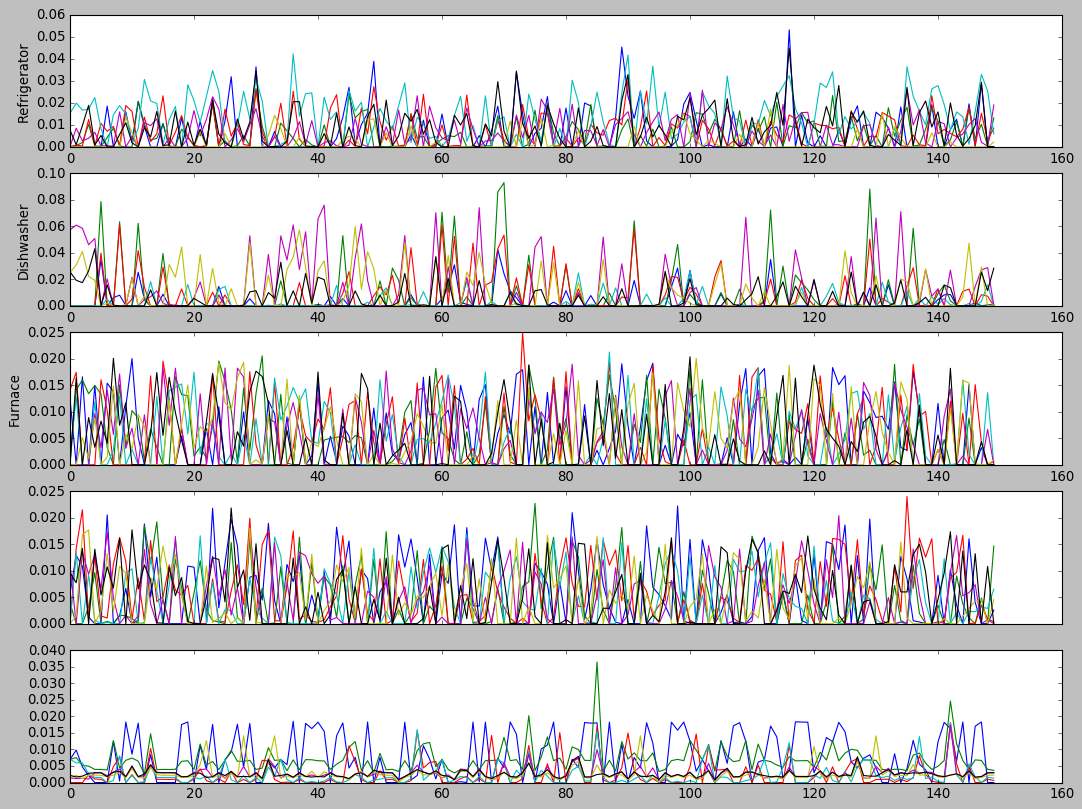

In [72]:
import matplotlib.pyplot as plt
plt.style.use('classic')

# row and column sharing
f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(5, 1, sharex='col', sharey='row', figsize=(16,12))
plt.rcParams.update({'font.size': 15})


for base in range(7):
    ax1.plot(range(n),B_list[0][base,0:])
    ax2.plot(range(n),B_list[1][base,0:])
    ax3.plot(range(n),B_list[2][base,0:])
    ax4.plot(range(n),B_list[3][base,0:])
    ax5.plot(range(n),B_list[4][base,0:])

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
# ax1.set_ylim([0,0.04])
ax1.set_ylabel('Refrigerator')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
# ax2.set_ylim([0,0.06])
ax2.set_ylabel('Dishwasher')
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
# ax3.set_ylim([0,0.02])
ax3.set_ylabel('Furnace')